In [1]:
import numpy as np
from scipy.stats import multivariate_normal, chi2
import random
import copy
from scipy.special import logsumexp
from scipy.spatial.distance import pdist, squareform
from random import shuffle, sample
import os
import sys
import matplotlib.pyplot as plt
from visualisation import plot_feature_space


# Add the folder functions to the system path
sys.path.append(os.path.abspath('../agents'))
sys.path.append(os.path.abspath('../stimuli'))

# Now you can import the function from get_content.py
from GMM_WM import GMMWM_Agent
from stim_utils import generate_test, generate_training_interleaved, generate_training_blocked, load_mat


In [2]:
def grid_search(n_train = 5, n_test = 7, order = 'interleaved', stimuli = None):

    if order == 'interleaved' and stimuli == None:
        X_train, y_train = generate_training_interleaved(5)
    elif stimuli == None:
        X_train, y_train = generate_training_blocked(5)
    else:
        X_train, y_train = stimuli

    X_test, y_test = generate_test(7)

    accuracy = 0
    for t in np.arange(0.2, 1, 0.1):
        for s in np.arange(0.4, 4, 0.2):
            agent = GMMWM_Agent(tot_memory = 7, 
                    threshold = t, 
                    sigma0 = s, 
                    decay = 0, 
                    phi = 0.3, 
                    start_p = 1, 
                    lr = 0.2,
                    switch = True)
            try:
                action_probs = agent(X_train, y_train)
                action_probs = agent(X_test, y_test, feedback = False)

                if np.sum(agent.reward_test)/len(agent.reward_test) > accuracy and len(agent.mu) <= 10:
                    accuracy = np.sum(agent.reward_test)/len(agent.reward_test)
                    print('New record:')
                    print('Accuracy =', accuracy)
                    print('Threshold =', t)
                    print('Sigma zero =', s)
                    print('N. of clusters:', len(agent.mu))
                    print('Final reliance on clusters:', agent.phi)
            except:
                print('error')
                print('Threshold =', t)
                print('Sigma zero =', s)



In [3]:
agent_config = {
    'Total memory' : 7,
    'Threshold' : 0.9,
    'Sigma0' : 2,
    'Minimum cluster lifetime' : 0,
    'Minimum cluster weight' : 0.05,
    'Cluster strategy weight' : 1, 
    'Initial uncertainty' : 1,
    'Strategy learning rate' : 0.1,
    'Fluid strategy' : False,
    'Pruning strategy' : {
        'name' : 'erasing', # can be 'merging' or 'erasing'
        'criterion' : 'oldest' # for 'merging' it can be 'KLD', 'euclidean distance' or 'mahalanobis distance', for 'erasing' it can be 'smallest' or 'oldest'
    }
}

In [9]:
X_train, y_train = generate_training_blocked(5)
print('training data successfully generated')
X_test, y_test = generate_test(7)


agent = GMMWM_Agent(agent_config)

p = agent(X_train, y_train, feedback = True)
p = agent(X_test, y_test, feedback = False)

print('Test accuracy:', np.sum(agent.reward_test)/len(agent.reward_test))

training data successfully generated
Test accuracy: 0.6388888888888888


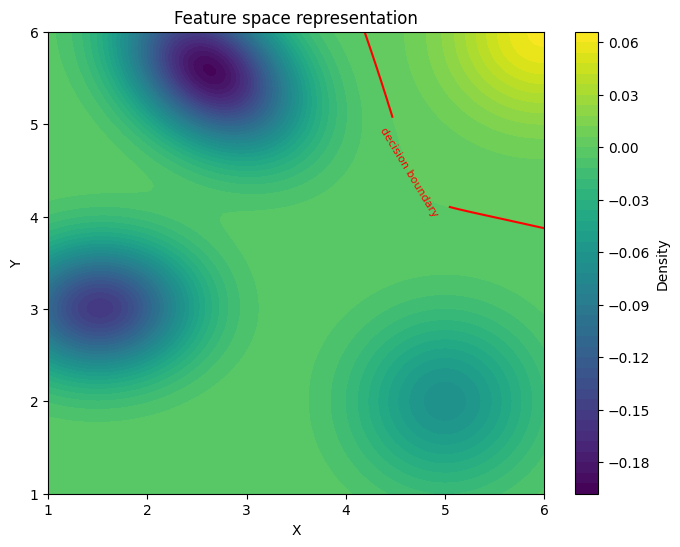

In [10]:
if agent.switch:
    plt.plot(agent.phis)
    plt.ylim([0, 1.05])

plot_feature_space(agent)

In [6]:
# See the statistics of each cluster
for c in range(len(agent.label)):
    print('Cluster ' + str(c+1) + ':')
    print('Label:', agent.label[c])
    print('Weight:', agent.alpha[c])
    print('Mean:', agent.mu[c])
    print('Covariance matrix:')
    print(agent.Sigma[c])
    print('--------------')

Cluster 1:
Label: 0
Weight: 10.847084700430548
Mean: [2.31298867 2.11471704]
Covariance matrix:
[[ 0.55994141 -0.14302424]
 [-0.14302424  0.28034719]]
--------------
Cluster 2:
Label: 1
Weight: 10.030234110022764
Mean: [5.26248707 3.13270192]
Covariance matrix:
[[ 0.57847074 -0.15365468]
 [-0.15365468  0.30725945]]
--------------
Cluster 3:
Label: 1
Weight: 3.783680624459455
Mean: [1.06200276 3.01970225]
Covariance matrix:
[[0.69616539 0.05215191]
 [0.05215191 0.5460143 ]]
--------------
Cluster 4:
Label: 0
Weight: 3.743395583890903
Mean: [3.99420296 3.95750105]
Covariance matrix:
[[0.66867904 0.00613301]
 [0.00613301 0.57248048]]
--------------


In [7]:
print(agent.sp)
print(agent.v)
print(len(X_train))

[15, 2, 0, 1]
[41, 27, 14, 12]
90
